# Desafio DataSprints - Fabio Kfouri

Este é um desafio dado pela <b><i>data <span style='color: red'>sprints</span></i></b> para avaliação técnica em Engenharia de Dados.

In [1]:
try:
    !pip install pyspark=="2.4.5" --quiet
    !pip install pandas=="1.0.4" --quiet
    !pip install seaborn=="0.9.0" --quiet
    !pip install boto3=="1.13.1" --quiet
    !pip install matplotlib=="3.2.2" --quiet
except:
    print("Running throw py file.")

In [2]:
import warnings
warnings.filterwarnings('ignore') #para ignorar mensagens de warnings

In [3]:
from pyspark import SparkContext as sc
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pyspark
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Criando uma SparkSession

In [4]:
spark = SparkSession\
        .builder\
        .appName("Desafio Data Sprints - Fabio Kfouri")\
        .getOrCreate()
spark

## Criação dos Dataframes
Referenciando o endereço das fontes. Para desenvolvimento local foi incluido as fontes na pasta <b>/data/</b>.

Para uso em cluster, sera usado o endereço do Bucket AWS <b>s3://data-sprints-eng-test/</b>.

In [5]:
import os
dirpath = os.getcwd()

dataPath = 'https://s3.amazonaws.com/data-sprints-eng-test/'
dataPath = 's3://data-sprints-eng-test/'
dataPath = dirpath + "/data/"
dataPath

'E:\\Projetos\\Jobs\\DataSprints/data/'

#### Leitura e Correçao da fonte Payment

In [6]:
df_payment = spark.read.csv(dataPath + 'data-payment_lookup-csv.csv', header = True, sep = ",")
df_payment.show(3)

+------------+--------------+
|           A|             B|
+------------+--------------+
|payment_type|payment_lookup|
|         Cas|          Cash|
|         CAS|          Cash|
+------------+--------------+
only showing top 3 rows



Verificado que a primeira linha precisa ser ignorada. Inclusao de index para auxiliar a correção.

In [7]:
df_payment = df_payment.withColumn('index', F.monotonically_increasing_id())
df_payment.show(3)

+------------+--------------+-----+
|           A|             B|index|
+------------+--------------+-----+
|payment_type|payment_lookup|    0|
|         Cas|          Cash|    1|
|         CAS|          Cash|    2|
+------------+--------------+-----+
only showing top 3 rows



Renomeando a coluna pelos valores pelo index zero. 

In [8]:
cols = df_payment.columns
values = df_payment.filter('index = 0').collect()
#print(cols, len(cols), values, len(values[0]), values[0])

for i in range(len(cols)):
    if cols[i] != 'index' :
        #print(i, cols[i], values[0][i])
        df_payment = df_payment.select(df_payment.columns).withColumnRenamed(cols[i], values[0][i])

Removendo a linha index zero.

In [9]:
df_payment = df_payment.filter('index<>0')
df_payment.show(3)

+------------+--------------+-----+
|payment_type|payment_lookup|index|
+------------+--------------+-----+
|         Cas|          Cash|    1|
|         CAS|          Cash|    2|
|         Cre|        Credit|    3|
+------------+--------------+-----+
only showing top 3 rows



Criação de view payment

In [10]:
df_payment.createOrReplaceTempView("payment")

#### Leitura da fonte de Vendor

In [11]:
df_vendor = spark.read.csv(dataPath + 'data-vendor_lookup-csv.csv', header = True, sep = ",")
df_vendor.show()

+---------+--------------------+--------------------+--------+-----+-----+-------+--------------------+-------+
|vendor_id|                name|             address|    city|state|  zip|country|             contact|current|
+---------+--------------------+--------------------+--------+-----+-----+-------+--------------------+-------+
|      CMT|Creative Mobile T...|950 4th Road Suit...|Brooklyn|   NY|11210|    USA|contactCMT@gmail.com|    Yes|
|      VTS|        VeriFone Inc|       26 Summit St.|Flushing|   NY|11354|    USA|   admin@vtstaxi.com|    Yes|
|      DDS|Dependable Driver...|8554 North Homest...|   Bronx|   NY|10472|    USA|          9778896500|    Yes|
|       TS|  Total Solutions Co|Five Boroughs Tax...|Brooklyn|   NY|11229|    USA|       mgmt@5btc.com|    Yes|
|       MT|           Mega Taxi| 4 East Jennings St.|Brooklyn|   NY|11228|    USA|contact@megataxic...|     No|
+---------+--------------------+--------------------+--------+-----+-----+-------+--------------------+-

Criação da view vendor.

In [12]:
df_vendor.createOrReplaceTempView("vendor")

## Leitura das corridas de taxi no período de 2009 à 2012

In [13]:
f_2009 = 'data-sample_data-nyctaxi-trips-2009-json_corrigido.json'
df_2009 = spark.read.json(dataPath + f_2009)
df_2009.count()

1000000

In [14]:
f_2010 = 'data-sample_data-nyctaxi-trips-2010-json_corrigido.json'
df_2010 = spark.read.json(dataPath + f_2010)

In [15]:
f_2011 = 'data-sample_data-nyctaxi-trips-2011-json_corrigido.json'
df_2011 = spark.read.json(dataPath + f_2011)

In [16]:
f_2012 = 'data-sample_data-nyctaxi-trips-2012-json_corrigido.json'
df_2012 = spark.read.json(dataPath + f_2012)

## Preparação do DataFrame de corridas de taxi.
Concatenando todos os dataFrames em único DataFrame e em seguinda verificando o total de linhas do DataFrame.

In [17]:
df = df_2012.union(df_2011).union(df_2010).union(df_2009)
print("Tamanho do DataFrame concatenado:", df.count(), 'registros')

Tamanho do DataFrame concatenado: 4000000 registros


Identificando o Schema do DataFrame

In [18]:
df.printSchema()

root
 |-- dropoff_datetime: string (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: long (nullable = true)
 |-- surcharge: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- vendor_id: string (nullable = true)



Visualizando o aspecto dos dados

In [19]:
df.show(5, truncate = False)

+--------------------------------+----------------+-----------------+-----------+---------------+------------+--------------------------------+---------------+----------------+---------+------------------+---------+----------+------------+------------+-------------+---------+
|dropoff_datetime                |dropoff_latitude|dropoff_longitude|fare_amount|passenger_count|payment_type|pickup_datetime                 |pickup_latitude|pickup_longitude|rate_code|store_and_fwd_flag|surcharge|tip_amount|tolls_amount|total_amount|trip_distance|vendor_id|
+--------------------------------+----------------+-----------------+-----------+---------------+------------+--------------------------------+---------------+----------------+---------+------------------+---------+----------+------------+------------+-------------+---------+
|2012-06-09T16:31:19.862787+00:00|40.74795        |-73.994712       |5.4        |2              |Cash        |2012-06-09T16:21:13.580003+00:00|40.74295       |-74.004114

Conversão de colunas [dropoff_datetime, pickup_datetime] do tipo String para tipo TimeStamp.

In [20]:
#DataFrame Convertido (dfc)
dfc = df.withColumn('dropoff_datetime', F.to_utc_timestamp('dropoff_datetime', "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'"))\
        .withColumn('pickup_datetime', F.to_utc_timestamp('pickup_datetime', "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'"))
dfc.printSchema()

root
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: long (nullable = true)
 |-- surcharge: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- vendor_id: string (nullable = true)



Visualizando o aspecto dos dados, em especial os campos dataTime

In [21]:
dfc.show(5, False)

+--------------------------+----------------+-----------------+-----------+---------------+------------+--------------------------+---------------+----------------+---------+------------------+---------+----------+------------+------------+-------------+---------+
|dropoff_datetime          |dropoff_latitude|dropoff_longitude|fare_amount|passenger_count|payment_type|pickup_datetime           |pickup_latitude|pickup_longitude|rate_code|store_and_fwd_flag|surcharge|tip_amount|tolls_amount|total_amount|trip_distance|vendor_id|
+--------------------------+----------------+-----------------+-----------+---------------+------------+--------------------------+---------------+----------------+---------+------------------+---------+----------+------------+------------+-------------+---------+
|2012-06-09 13:31:19.862787|40.74795        |-73.994712       |5.4        |2              |Cash        |2012-06-09 13:21:13.580003|40.74295       |-74.004114      |null     |null              |0.0      |0.

Criando uma view trip.

In [22]:
dfc.createOrReplaceTempView("trip")

## Questões do Quesito Mínimo

<b>Questão 1</b>: Qual a distância média percorrida por viagens com no máximo 2 passageiros.

A distância média (valor arredondado) percorrida por viagens com no máximo 2 passageiros é:

In [23]:
df_question_1 = spark.sql("""
      SELECT ROUND(AVG(trip_distance),3) mean_trip_distance
        FROM trip t
       WHERE t.passenger_count <= 2
""")
df_question_1.show()

+------------------+
|mean_trip_distance|
+------------------+
|             2.663|
+------------------+



<b>Questão 2</b>: Quais os 3 maiores vendors em quantidade total de dinheiro arrecadado?

O resultado em quantidade de dinheiro (valores em Milhões U$) arrecado pelos 3 maiores vendors são:

In [24]:
df_question_2 = spark.sql("""
    SELECT v.name, t.vendor_id, ROUND(SUM(total_amount)/1E6,3) amount 
      FROM trip t LEFT JOIN vendor v ON (t.vendor_id = v.vendor_id)
  GROUP BY t.vendor_id, v.name
  ORDER BY SUM(total_amount) DESC
     LIMIT 3
""")
df_question_2.show(truncate = False)

+---------------------------------+---------+------+
|name                             |vendor_id|amount|
+---------------------------------+---------+------+
|Creative Mobile Technologies, LLC|CMT      |19.549|
|VeriFone Inc                     |VTS      |19.043|
|Dependable Driver Service, Inc   |DDS      |2.715 |
+---------------------------------+---------+------+



<b>Questão 3</b>: Um histograma da distribuição mensal, nos 4 anos, de corridas pagas em dinheiro:

In [25]:
df_question_3 = spark.sql("""
    WITH Dist as (--
        SELECT date_format(t.dropoff_datetime,'MMM-yyyy') month_year,
               date_format(t.dropoff_datetime,'yyyy-MM') my_idx,
               date_format(t.dropoff_datetime,'MMM') month,
               date_format(t.dropoff_datetime,'MM') m_idx, 
               p.payment_lookup, t.total_amount--, t.*
          FROM trip t JOIN payment p ON (t.payment_type = p.payment_type)
         WHERE p.payment_lookup = 'Cash' --
    )
    SELECT count(month) qty_trip, sum(total_amount) amount, month_year, my_idx, month, m_idx
      FROM Dist d
  GROUP BY month_year, my_idx, month, m_idx
  ORDER BY my_idx
""")
df_question_3.show()

+--------+-----------------+----------+-------+-----+-----+
|qty_trip|           amount|month_year| my_idx|month|m_idx|
+--------+-----------------+----------+-------+-----+-----+
|   66980|628682.9800000001|  Jan-2009|2009-01|  Jan|   01|
|   66817|626358.3499999989|  Feb-2009|2009-02|  Feb|   02|
|   73944|696470.6700000003|  Mar-2009|2009-03|  Mar|   03|
|   71139|667427.1799999996|  Apr-2009|2009-04|  Apr|   04|
|   74140|698284.0399999991|  May-2009|2009-05|  May|   05|
|   71365|669824.8000000002|  Jun-2009|2009-06|  Jun|   06|
|   74082|697670.9999999999|  Jul-2009|2009-07|  Jul|   07|
|   73995|696738.1899999992|  Aug-2009|2009-08|  Aug|   08|
|   71531|671673.8400000002|  Sep-2009|2009-09|  Sep|   09|
|   73911|694842.2299999995|  Oct-2009|2009-10|  Oct|   10|
|   71413|670084.0199999992|  Nov-2009|2009-11|  Nov|   11|
|   21396|202496.8000000001|  Dec-2009|2009-12|  Dec|   12|
|   66371|624254.5599999995|  Jan-2010|2010-01|  Jan|   01|
|   66944|626000.1800000007|  Feb-2010|2

In [26]:
dados = df_question_3.toPandas()

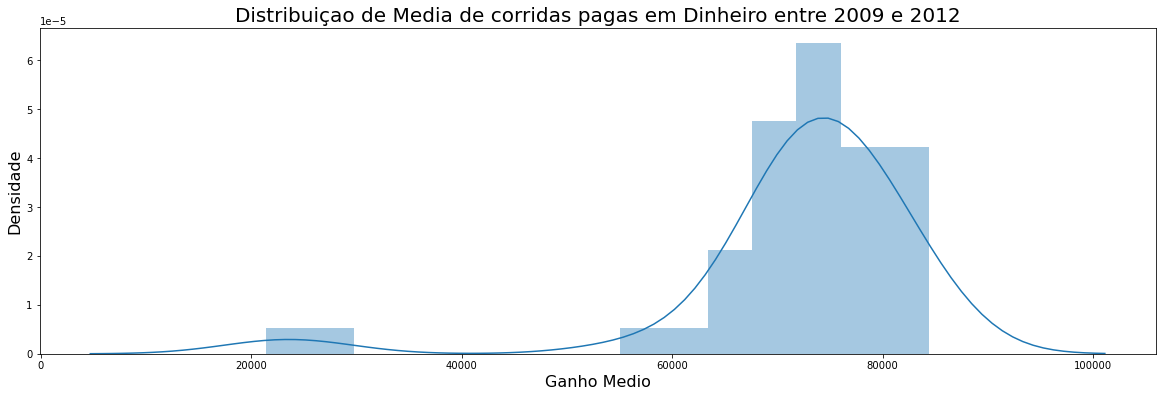

In [27]:
ax = sns.distplot(dados.qty_trip)
ax.figure.set_size_inches(20, 6)
ax.set_xlabel('Ganho Medio', fontsize=16)
ax.set_ylabel('Densidade', fontsize=16)
ax.set_title("Distribuiçao de Media de corridas pagas em Dinheiro entre 2009 e 2012", fontsize=20)
ax

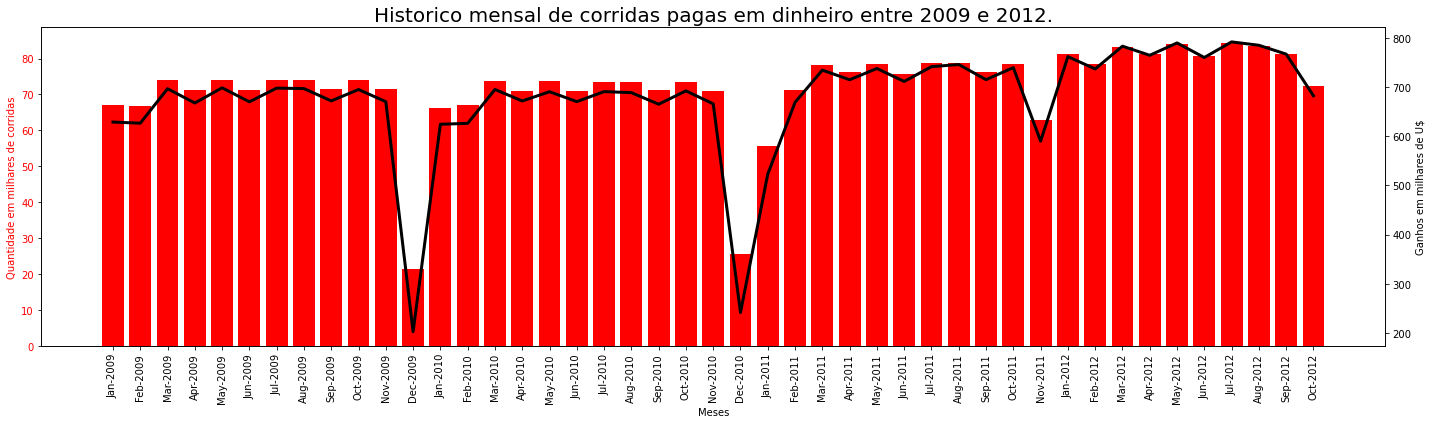

In [28]:
fig, ax1 = plt.subplots()
color = 'red'
ax1.set_title("Historico mensal de corridas pagas em dinheiro entre 2009 e 2012.", fontsize=20)
ax1.set_xlabel('Meses')
ax1.figure.set_size_inches(20, 6)
plt.xticks(rotation='vertical')

# Eixo primario
ax1.set_ylabel('Quantidade em milhares de corridas', color=color)
ax1.bar(dados.month_year, dados.qty_trip/1E3, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Eixo secundario
ax2 = ax1.twinx() 
color = 'black'
ax2.set_ylabel('Ganhos em milhares de U$', color=color) 
ax2.plot(dados.month_year, dados.amount/1E3, color=color, linewidth=3)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 


<b>Questão 4</b>: Um gráfico de série temporal contando a quantidade de gorjetas de cada dia, nos
últimos 3 meses de 2012:

In [29]:
df_question_4 = spark.sql("""
WITH
last_month AS (--
     SELECT date_add(add_months(to_date(date_format(MAX(dropoff_datetime),'yyyy-MM') || '-01','yyyy-MM-dd'),1),-1) last_date,
            MAX(dropoff_datetime) max_date,
            add_months(to_date(date_format(MAX(dropoff_datetime),'yyyy-MM') || '-01','yyyy-MM-dd'),-2) first_date
       FROM trip --
),
temp AS (--
     SELECT dropoff_datetime, 
            date_format(t.dropoff_datetime,'dd-MMM-yyyy') month_year,
            date_format(t.dropoff_datetime,'yyyy-MM-dd') my_idx, tip_amount
       FROM trip t, last_month lm
      WHERE dropoff_datetime between lm.first_date and lm.last_date
        AND tip_amount > 0 -- corridas que tiveram gorjetas
      )
      SELECT month_year, my_idx, COUNT(tip_amount) tips from temp
       GROUP BY month_year, my_idx
       ORDER BY my_idx   
""")
df_question_4.show(5, truncate = False)

+-----------+----------+----+
|month_year |my_idx    |tips|
+-----------+----------+----+
|01-Aug-2012|2012-08-01|590 |
|02-Aug-2012|2012-08-02|617 |
|03-Aug-2012|2012-08-03|600 |
|04-Aug-2012|2012-08-04|602 |
|05-Aug-2012|2012-08-05|556 |
+-----------+----------+----+
only showing top 5 rows



In [30]:
dados = df_question_4.toPandas()
dados.head()

,month_year,my_idx,tips
0,01-Aug-2012,2012-08-01,590
1,02-Aug-2012,2012-08-02,617
2,03-Aug-2012,2012-08-03,600
3,04-Aug-2012,2012-08-04,602
4,05-Aug-2012,2012-08-05,556


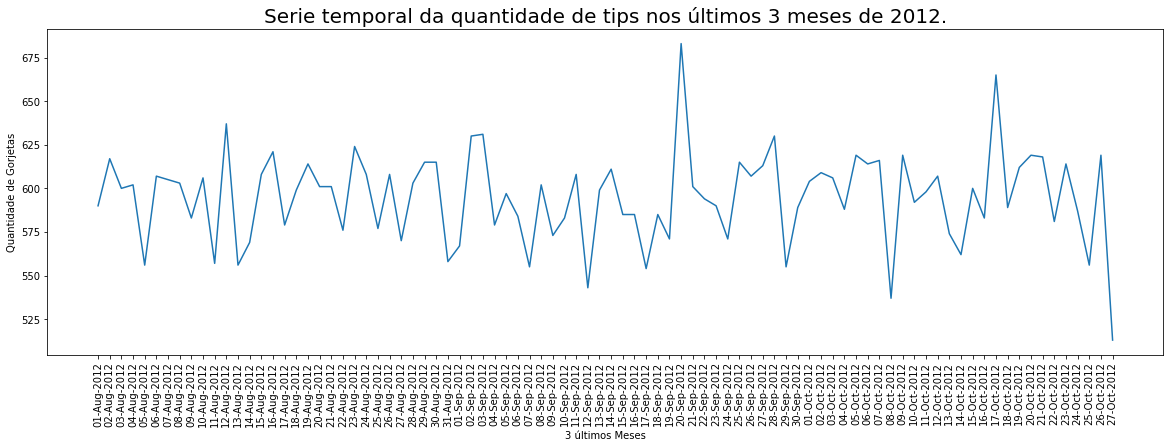

In [31]:
fig, ax1 = plt.subplots()

ax1.set_title("Serie temporal da quantidade de tips nos últimos 3 meses de 2012.", fontsize=20)
ax1.set_xlabel('3 últimos Meses')
ax1.figure.set_size_inches(20, 6)
plt.xticks(rotation='vertical')
# Eixo primario
ax1.set_ylabel('Quantidade de Gorjetas')
ax1.plot(dados.month_year, dados.tips ) 

## Questões do Quesito Bônus

<b>Questão 5</b>: Qual o tempo médio das corridas nos dias de sábado e domingo?

O tempo médio das corridas no fim de semana é:

In [32]:
df_question_5 = spark.sql("""
WITH calc as (--
      SELECT dayofweek(t.dropoff_datetime) day_week_num, 
             date_format(t.dropoff_datetime, 'EEEE') day_week, 
             dropoff_datetime, pickup_datetime,
             cast(dropoff_datetime as long) - cast(pickup_datetime as long) delta,
             t.trip_distance
        FROM trip t
        WHERE dayofweek(t.dropoff_datetime) in (1,7) --
)
--SELECT c.*, round(delta/60, 2) delta_minutes, round(delta/60/60, 2) delta_hour FROM calc c
    SELECT avg(delta) delta_seconds, 
           round(avg(delta/60), 2) delta_minutes, day_week
      FROM calc
  GROUP BY day_week

""")
df_question_5.show(5, False)

+-----------------+-------------+--------+
|delta_seconds    |delta_minutes|day_week|
+-----------------+-------------+--------+
|524.8550007748225|8.75         |Saturday|
|524.7120638128082|8.75         |Sunday  |
+-----------------+-------------+--------+



<b>Questão 6</b>: Fazer uma visualização em mapa com latitude e longitude de pickups and dropoffs no ano
de 2010.

In [33]:
df_question_6 = spark.sql("""
      SELECT dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude
        FROM trip t
       WHERE date_format(t.dropoff_datetime,'yyyy') = 2010
""")
df_question_6.show(5, False)

+----------------+-----------------+---------------+----------------+
|dropoff_latitude|dropoff_longitude|pickup_latitude|pickup_longitude|
+----------------+-----------------+---------------+----------------+
|40.74795        |-73.994712       |40.74295       |-74.004114      |
|40.792385       |-73.940449       |40.747784      |-73.996506      |
|40.768108       |-73.944535       |40.75207       |-73.95134       |
|40.721812       |-73.958122       |40.729128      |-74.001117      |
|40.776075       |-73.979757       |40.756873      |-73.9766        |
+----------------+-----------------+---------------+----------------+
only showing top 5 rows



Encontrando os extremos latitude e longitude. 

Verificado a existencia de <b>Outliers</b> para Latitude e Longitude.

In [34]:
df_question_6a = spark.sql("""
WITH map as (--
      SELECT dropoff_latitude latitude, dropoff_longitude longitude
        FROM trip t
       WHERE date_format(t.dropoff_datetime,'yyyy') = 2010
    UNION
     SELECT pickup_latitude, pickup_longitude
        FROM trip t
       WHERE date_format(t.dropoff_datetime,'yyyy') = 2010
)
Select *
       --min(latitude) min_latitude, max(latitude) max_latitude, avg(latitude) avg_latitude
       --min(longitude) min_longitude, max(longitude) max_longitude, avg(longitude) avg_longitude
       from map m
""")
df_question_6a.show(5, False)

+---------+----------+
|latitude |longitude |
+---------+----------+
|40.759317|-73.985112|
|40.767015|-73.953683|
|40.736537|-73.994712|
|40.759755|-73.983478|
|40.779957|-73.982774|
+---------+----------+
only showing top 5 rows



Conversão para Pandas e realizado uma análise das Estatísticas Descritivas para identificação dos <b>Outliers</b>. 

Observa-se que os valores mínimo e máximo de latitude e longitude estão bem distantes dos Quartis. 

In [35]:
dados = df_question_6a.toPandas()
dados.describe().round(3)

,latitude,longitude
count,1932099.000,1932099.000
mean,40.753,-73.974
std,0.135,0.223
min,-0.015,-84.878
25%,40.737,-73.991
50%,40.755,-73.981
75%,40.769,-73.967
max,47.936,0.009


Definindo o limite inferior e superior para Latitude.

In [36]:
Q1 = dados['latitude'].quantile(.25)
Q3 = dados['latitude'].quantile(.75)
IIQ = Q3 - Q1
limite_inferior_latitude = Q1 - 1.5 * IIQ
limite_superior_latitude = Q3 + 1.5 * IIQ
print(limite_inferior_latitude, limite_superior_latitude, Q1, Q3)

40.68909299999999 40.817037000000006 40.737072 40.769058


Definindo o limite inferior e superior para Longitude.

In [37]:
Q1 = dados['longitude'].quantile(.25)
Q3 = dados['longitude'].quantile(.75)
IIQ = Q3 - Q1
limite_inferior_longitude = Q1 - 1.5 * IIQ
limite_superior_longitude = Q3 + 1.5 * IIQ
print(limite_inferior_longitude, limite_superior_longitude, Q1, Q3)

-74.02756500000001 -73.93020499999997 -73.991055 -73.966715


Aplicando a limpeza do DataSet pelos limites calculados de Latitude e Longetude.

In [38]:
selecao = (dados['latitude'] >= limite_inferior_latitude) & (dados['latitude']<= limite_superior_latitude) & \
          (dados['longitude'] >= limite_inferior_longitude) & (dados['longitude']<= limite_superior_longitude) 
dados_new = dados[selecao]

Este é um check para evidenciar que o novo DataSet é menor que o DataSet original.

In [39]:
print(dados.shape, dados_new.shape)

(1932099, 2) (1795890, 2)


Observa-se que no novo Dataset não há inconsistências.

In [40]:
dados_new.describe().round(3)

,latitude,longitude
count,1795890.000,1795890.000
mean,40.754,-73.980
std,0.022,0.016
min,40.689,-74.028
25%,40.738,-73.991
50%,40.755,-73.982
75%,40.769,-73.970
max,40.817,-73.930


Seguindo o tutorial https://towardsdatascience.com/easy-steps-to-plot-geographic-data-on-a-map-python-11217859a2db.

In [41]:
print('Latitude:', dados_new['latitude'].min(), 'e', dados_new['latitude'].max())
print('Longitude:', dados_new['longitude'].min(), 'e', dados_new['longitude'].max())

Latitude: 40.689093 e 40.817036
Longitude: -74.027507 e -73.930205


In [ ]:
try:
    !pip install ipyleaflet --quiet
except:
    print("Running throw py file.")

In [ ]:
try:
    #!conda install geopandas
    !pip uninstall geopandas --quiet
    #!pip install git+git://github.com/geopandas/geopandas.git
except:
    print("Running throw py file.")

In [48]:
import descartes
import geopandas as gpd

from shapely.geometry import Point, Polygon

ModuleNotFoundError: No module named 'geopandas'